In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import random

In [3]:
# Importing the test and train data (20/80 split), and the full dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
full_data = pd.read_csv('cleaned_data/diabetes_cleaned.csv')

# Removing the first column
train = train.iloc[:, 1:]
test = test.iloc[:, 1:]
full_data = full_data.iloc[:, 1:]

In [4]:
# Following the method used in KEH_LTW modeling notebook to create a train dataset 
# that has an equal distribution of (0) and (1) response
# 1. Determine the observations with (1) response. Let this be n observations.
#   MODIFICATION: pull the (1) response from the full dataset to increase the number of observations
# 2. Randomly sample n observations with (0) response, and combine in a new train dataset with (1) response observations.
# 3. Randomly shuffle the new train dataset

admitted = full_data.loc[full_data.readmitted == 1, :]
n = admitted.shape[0]

not_readmitted = full_data.loc[full_data.readmitted == 0, :].sample(n)

train1 = pd.concat([admitted, not_readmitted])
train1 = train1.sample(frac = 1)

In [5]:
train1.readmitted.value_counts()

1    6293
0    6293
Name: readmitted, dtype: int64

#### Summary of KEH LTW Modeling

Variables that have a relationship with `readmitted`, from full dataset EDA:
- `age`: as age increases, the proportion of individuals readmitted to the hospital increases. The number of observations overall increases. This trend persists until age 75, after which the number of hospital visits drop and the proportion of readmitted : not readmitted evens out. This variable is already binned by nature of our original dataset.
    - -> because different age ranges have different distributions of readmitted : not readmitted, look into making each age bin its own predictor, if this isn't happening already
- `time_in_hospital`: as time in hospital increases, the number of observations increase (up until 3 days), and then start to decrease. The ratio of readmitted : not readmitted gradually increases as `time_in_hospital` increases.
    - -> the different distribution of readmittied: not readmitted at for each value of `time_in_hospital`. Similarly, look into making each day bin its own predictor, if it isn't already
- `num_of_changes`: there doesn't seem to be much difference 
- `number_inpatient`: large difference!

Interactions
- as `age` increases, the `time_in_hospital` increases
- as `time_in_hospital` increases, the `um_of_changes` also increases

Models
1. `readmitted ~ time_in_hospital*age + num_of_changes + number_inpatient`
2. `readmitted ~ num_of_changes*time_in_hospital + number_inpatient + age`
3. `readmitted ~ num_of_changes*time_in_hospital + age*time_in_hospital + number_inpatient`

Thoughts
- More variable selection
    - diag_1, diag_2, diag_3
    - num_medications
    - num_lab_procedures
- Make the bins in `age` and `time_in_hospital` their own predictors
- Evaluate performance of the existing KEH-LTW models with k-fold cross-validation
- Look to see if there are other interactions or transformations

Text(0.5, 0, 'age')

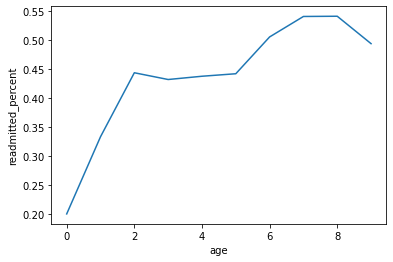

In [6]:
#Re-creating the plot of diabetes_percent vs age created earlier, just to check if the function binned age correctly. Yes, it did.
age_data = train1.groupby('age')['readmitted'].agg([('readmitted_percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = age_data.index, y= age_data['readmitted_percent'])
plt.xlabel('age')

Text(0.5, 0, 'time_in_hospital')

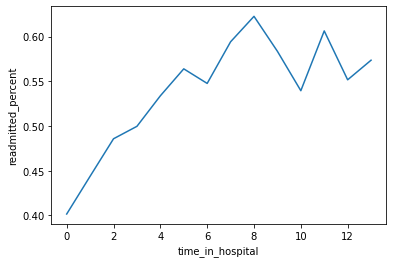

In [7]:
#Re-creating the plot of diabetes_percent vs age created earlier, just to check if the function binned age correctly. Yes, it did.
time_data = train1.groupby('time_in_hospital')['readmitted'].agg([('readmitted_percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = time_data.index, y= time_data['readmitted_percent'])
plt.xlabel('time_in_hospital')

#### KEH_LTW function for calculating confusion matrix and other evaluation statistics

In [8]:
from sklearn.metrics import roc_curve, auc

#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

#### Creating a dataframe containing dummy variables for all binned variables

In [141]:
dummy_preds = ["age", "time_in_hospital", "admission_type_id", "discharge_disposition_id", "admission_source_id"]
train1_dummy = train1.copy()
test_dummy = test.copy()
vars = []

for pred in dummy_preds:
    dummy_train = pd.get_dummies(train1.loc[:, pred])
    dummy_train.columns = [pred + str(x) for x in dummy_train.columns]
    train1_dummy = pd.concat([train1_dummy, dummy_train], axis=1)
    vars.append(list(dummy_train.columns))
    
    dummy_test = pd.get_dummies(test.loc[:, pred])
    dummy_test.columns = [pred + str(x) for x in dummy_test.columns]
    test_dummy = pd.concat([test_dummy, dummy_test], axis=1)
    

train1_dummy.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'num_of_changes', 'age5', 'age15', 'age25', 'age35', 'age45', 'age55',
       'age65', 'age75', 'age85', 'age95', 't

In [173]:
train1_dummy.corrwith(train1_dummy.readmitted).sort_values()

discharge_disposition_id1    -0.144392
discharge_disposition_id11   -0.100156
encounter_id                 -0.084463
time_in_hospital1            -0.077951
time_in_hospital2            -0.050400
age55                        -0.050108
age45                        -0.039584
age15                        -0.026323
age35                        -0.025663
age5                         -0.020726
admission_source_id4         -0.017522
admission_type_id3           -0.016670
age25                        -0.013791
time_in_hospital3            -0.012762
discharge_disposition_id27   -0.012607
admission_source_id1         -0.004273
age95                        -0.001960
admission_type_id            -0.001907
discharge_disposition_id18   -0.000373
admission_source_id9         -0.000308
time_in_hospital4            -0.000234
num_procedures                0.002516
age65                         0.006116
discharge_disposition_id7     0.006321
admission_type_id5            0.007978
admission_type_id1       

In [180]:
corr_table = train1_dummy.corr()
corr_table.iloc[26:40, 26:40]

,time_in_hospital1,time_in_hospital2,time_in_hospital3,time_in_hospital4,time_in_hospital5,time_in_hospital6,time_in_hospital7,time_in_hospital8,time_in_hospital9,time_in_hospital10,time_in_hospital11,time_in_hospital12,time_in_hospital13,time_in_hospital14
time_in_hospital1,1.000000,-0.177884,-0.177833,-0.155148,-0.130233,-0.114953,-0.104471,-0.087799,-0.069821,-0.063693,-0.052238,-0.048795,-0.042779,-0.040323
time_in_hospital2,-0.177884,1.000000,-0.201470,-0.175769,-0.147543,-0.130232,-0.118357,-0.099469,-0.079101,-0.072159,-0.059181,-0.055280,-0.048464,-0.045683
time_in_hospital3,-0.177833,-0.201470,1.000000,-0.175719,-0.147501,-0.130195,-0.118323,-0.099441,-0.079079,-0.072139,-0.059164,-0.055265,-0.048451,-0.045670
time_in_hospital4,-0.155148,-0.175769,-0.175719,1.000000,-0.128685,-0.113586,-0.103229,-0.086756,-0.068991,-0.062936,-0.051617,-0.048215,-0.042270,-0.039844
time_in_hospital5,-0.130233,-0.147543,-0.147501,-0.128685,1.000000,-0.095346,-0.086652,-0.072824,-0.057912,-0.052830,-0.043328,-0.040472,-0.035482,-0.033446
time_in_hospital6,-0.114953,-0.130232,-0.130195,-0.113586,-0.095346,1.000000,-0.076485,-0.064279,-0.051117,-0.046631,-0.038244,-0.035723,-0.031319,-0.029521
time_in_hospital7,-0.104471,-0.118357,-0.118323,-0.103229,-0.086652,-0.076485,1.000000,-0.058418,-0.046456,-0.042379,-0.034757,-0.032466,-0.028463,-0.026830
time_in_hospital8,-0.087799,-0.099469,-0.099441,-0.086756,-0.072824,-0.064279,-0.058418,1.000000,-0.039042,-0.035616,-0.029210,-0.027285,-0.023921,-0.022548
time_in_hospital9,-0.069821,-0.079101,-0.079079,-0.068991,-0.057912,-0.051117,-0.046456,-0.039042,1.000000,-0.028323,-0.023229,-0.021698,-0.019023,-0.017931
time_in_hospital10,-0.063693,-0.072159,-0.072139,-0.062936,-0.052830,-0.046631,-0.042379,-0.035616,-0.028323,1.000000,-0.021191,-0.019794,-0.017353,-0.016357


#### Inspecting the existing models

Model 1: `readmitted ~ time_in_hospital*age + num_of_changes + number_inpatient`

In [9]:

logit_model = sm.logit(formula = 'readmitted ~ time_in_hospital*age + num_of_changes + number_inpatient', data = train1).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.674435
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                12586
Model:                          Logit   Df Residuals:                    12580
Method:                           MLE   Df Model:                            5
Date:                Thu, 23 Feb 2023   Pseudo R-squ.:                 0.02700
Time:                        23:53:29   Log-Likelihood:                -8488.4
converged:                       True   LL-Null:                       -8724.0
Covariance Type:            nonrobust   LLR p-value:                 1.435e-99
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.2212      0.140     -8.731      0.000      -1.495      -0.947
time_in_hospital         0.1059      0.028      3.736      0.000       0.050       0.161
age                      0.0124      0.002      5.987      0.000       0.008       0.016
time_in_hospital:age    -0.0007      0.000     -1.659      0.097      -0.001       0.000
num_of_changes           0.1106      0.038      2.876      0.004       0.035       0.186
number_inpatient         0.4195      0.030     14.055      0.000       0.361       0.478
========================================================================================
"""

-8488.441402884093

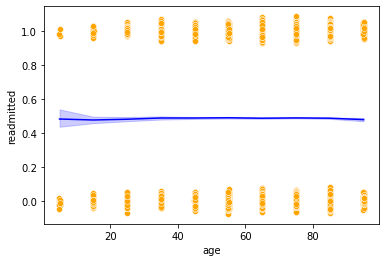

In [10]:
# Question: Can we visualize the logistic model in a multidimensional space, to account for all parameters used in the model?

def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)

sns.scatterplot(x = jitter(train1.age,0), y = jitter(train1.readmitted,0), data = train1, color = 'orange')
sns.lineplot(x = 'age', y= logit_model.predict(train), data = train1, color = 'blue') 
logit_model.llf



Classification accuracy = 57.7%
Precision = 59.0%
TPR or Recall = 50.6%
FNR = 49.4%
FPR = 35.2%
ROC-AUC = 60.7%


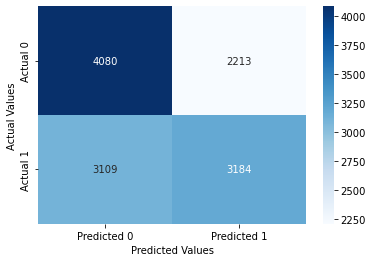

In [11]:
confusion_matrix_data(train1, train1.readmitted, logit_model, cutoff=0.5)

Classification accuracy = 62.5%
Precision = 12.4%
TPR or Recall = 50.8%
FNR = 49.2%
FPR = 36.3%
ROC-AUC = 60.2%


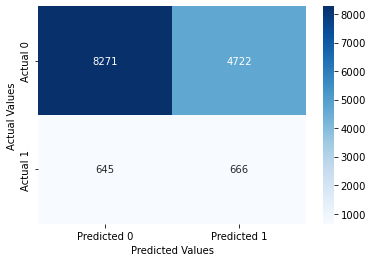

In [12]:
confusion_matrix_data(test, test.readmitted, logit_model, cutoff=0.5)

In [ ]:
# cross validation


Model 1.1 -- Making each age group its own predictor

In [145]:
'readmitted ~ ' + ' + '.join(vars[0])

'readmitted ~ age5 + age15 + age25 + age35 + age45 + age55 + age65 + age75 + age85 + age95'

In [146]:
logit_model_age_dummy = sm.logit(formula = 'readmitted ~ ' + ' + '.join(vars[0]), data = train1_dummy).fit() 
logit_model_age_dummy.summary()

         Current function value: 0.688852
         Iterations: 35


/Users/amywang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                12586
Model:                          Logit   Df Residuals:                    12575
Method:                           MLE   Df Model:                           10
Date:                Fri, 24 Feb 2023   Pseudo R-squ.:                0.006196
Time:                        01:20:20   Log-Likelihood:                -8669.9
converged:                      False   LL-Null:                       -8724.0
Covariance Type:            nonrobust   LLR p-value:                 1.281e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2482        nan        nan        nan         nan         nan
age5          -1.1381        nan        nan        nan         nan         nan
age15         -0.4450        nan        nan        nan         nan         nan
age25          0.0226        nan        nan        nan         nan         nan
age35         -0.0248        nan        nan        nan         nan         nan
age45         -0.0018        nan        nan        nan         nan         nan
age55          0.0157        nan        nan        nan         nan         nan
age65          0.2711        nan        nan        nan         nan         nan
age75          0.4129        nan        nan        nan         nan         nan
age85          0.4145        nan        nan        nan         nan         nan
age95          0.2246        nan        nan        nan         nan         nan
==============================================================================
"""

In [147]:
'time_in_hospital + ' + ' + '.join(vars[0])

'time_in_hospital + age5 + age15 + age25 + age35 + age45 + age55 + age65 + age75 + age85 + age95'

Classification accuracy = 53.9%
Precision = 52.9%
TPR or Recall = 70.5%
FNR = 29.5%
FPR = 62.7%
ROC-AUC = 54.8%


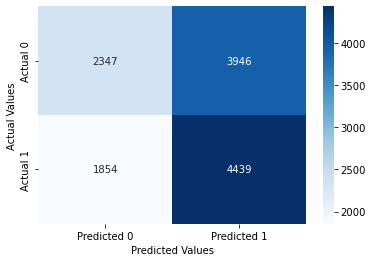

In [148]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, logit_model_age_dummy, cutoff=0.5)

Classification accuracy = 40.0%
Precision = 10.1%
TPR or Recall = 70.0%
FNR = 30.0%
FPR = 63.0%
ROC-AUC = 54.0%


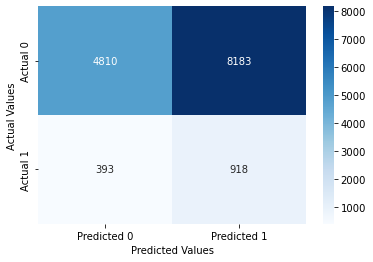

In [149]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, logit_model_age_dummy, cutoff=0.5)

Quick observations
- The classification accuracy for the test data decreased compared to the train data, suggesting overfitting.
- Precision decreased --> among the classified positives, not many are true positives
- This trend is reflected in the highest false positive rate
- ROC-AUC went down

But now the model is classifying datapoints as positive!

In [150]:
form = 'readmitted ~ time_in_hospital + ' + ' + '.join(vars[0]) + ' + num_of_changes + number_inpatient'
form

'readmitted ~ time_in_hospital + age5 + age15 + age25 + age35 + age45 + age55 + age65 + age75 + age85 + age95 + num_of_changes + number_inpatient'

In [151]:
# try adding the other terms of the model and the age predictors

logit_model_age_dummy_2 = sm.logit(formula = form, data = train1_dummy).fit() 
logit_model_age_dummy_2.summary()

Optimization terminated successfully.
         Current function value: 0.673769
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                12586
Model:                          Logit   Df Residuals:                    12572
Method:                           MLE   Df Model:                           13
Date:                Fri, 24 Feb 2023   Pseudo R-squ.:                 0.02796
Time:                        01:21:31   Log-Likelihood:                -8480.1
converged:                       True   LL-Null:                       -8724.0
Covariance Type:            nonrobust   LLR p-value:                 5.711e-96
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5860        nan        nan        nan         nan         nan
time_in_hospital     0.0596      0.006      9.504      0.000       0.047       0.072
age5                -1.0101        nan        nan        nan         nan         nan
age15               -0.4568        nan        nan        nan         nan         nan
age25               -0.0699        nan        nan        nan         nan         nan
age35               -0.0764        nan        nan        nan         nan         nan
age45               -0.0335        nan        nan        nan         nan         nan
age55               -0.0197        nan        nan        nan         nan         nan
age65                0.2182        nan        nan        nan         nan         nan
age75                0.3428        nan        nan        nan         nan         nan
age85                0.3340        nan        nan        nan         nan         nan
age95                0.1854        nan        nan        nan         nan         nan
num_of_changes       0.1091      0.038      2.834      0.005       0.034       0.185
number_inpatient     0.4168      0.030     13.965      0.000       0.358       0.475
====================================================================================
"""

Classification accuracy = 57.6%
Precision = 59.5%
TPR or Recall = 47.7%
FNR = 52.3%
FPR = 32.5%
ROC-AUC = 61.0%


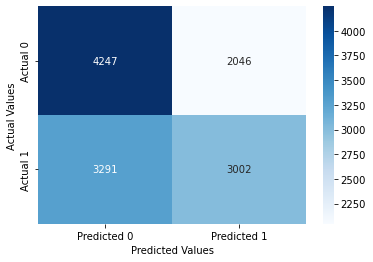

In [152]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, logit_model_age_dummy_2,cutoff=0.5)

Classification accuracy = 65.0%
Precision = 12.7%
TPR or Recall = 48.0%
FNR = 52.0%
FPR = 33.3%
ROC-AUC = 60.6%


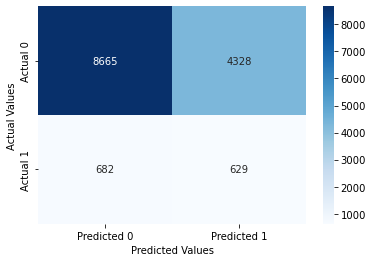

In [153]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, logit_model_age_dummy_2,cutoff=0.5)

Quick observations
- clssification accuracy of test data went up

In [154]:
# Predictors: all age groups, interactions between time_in_hospital and the age groups, num_of_changes, and number_inpatient
form = 'readmitted ~ time_in_hospital*{} + num_of_changes + number_inpatient'.format('time_in_hospital*'.join([(x + " + ") for x in vars[0][:-1]]) + 'time_in_hospital*age95')
form

'readmitted ~ time_in_hospital*age5 + time_in_hospital*age15 + time_in_hospital*age25 + time_in_hospital*age35 + time_in_hospital*age45 + time_in_hospital*age55 + time_in_hospital*age65 + time_in_hospital*age75 + time_in_hospital*age85 + time_in_hospital*age95 + num_of_changes + number_inpatient'

In [155]:
# all predictors (and interaction) of original logit_model

logit_model_age_dummy_3 = sm.logit(formula = form, data = train1_dummy).fit() 
logit_model_age_dummy_3.summary()

         Current function value: 0.673421
         Iterations: 35


/Users/amywang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                12586
Model:                          Logit   Df Residuals:                    12563
Method:                           MLE   Df Model:                           22
Date:                Fri, 24 Feb 2023   Pseudo R-squ.:                 0.02846
Time:                        01:22:13   Log-Likelihood:                -8475.7
converged:                      False   LL-Null:                       -8724.0
Covariance Type:            nonrobust   LLR p-value:                 3.841e-91
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.9802        nan        nan        nan         nan         nan
time_in_hospital           0.2310        nan        nan        nan         nan         nan
age5                      -4.4614        nan        nan        nan         nan         nan
time_in_hospital:age5      1.5992        nan        nan        nan         nan         nan
age15                     -0.4382        nan        nan        nan         nan         nan
time_in_hospital:age15    -0.0337        nan        nan        nan         nan         nan
age25                      0.2588        nan        nan        nan         nan         nan
time_in_hospital:age25    -0.1526        nan        nan        nan         nan         nan
age35                      0.1896        nan        nan        nan         nan         nan
time_in_hospital:age35    -0.1372        nan        nan        nan         nan         nan
age45                      0.3606        nan        nan        nan         nan         nan
time_in_hospital:age45    -0.1715        nan        nan        nan         nan         nan
age55                      0.3449        nan        nan        nan         nan         nan
time_in_hospital:age55    -0.1645        nan        nan        nan         nan         nan
age65                      0.6231        nan        nan        nan         nan         nan
time_in_hospital:age65    -0.1740        nan        nan        nan         nan         nan
age75                      0.7041        nan        nan        nan         nan         nan
time_in_hospital:age75    -0.1645        nan        nan        nan         nan         nan
age85                      0.8329        nan        nan        nan         nan         nan
time_in_hospital:age85    -0.1933        nan        nan        nan         nan         nan
age95                      0.6053        nan        nan        nan         nan         nan
time_in_hospital:age95    -0.1768        nan        nan        nan         nan         nan
num_of_changes             0.1106      0.039      2.871      0.004       0.035       0.186
number_inpatient           0.4168      0.030     13.968      0.000       0.358       0.475
==========================================================================================
"""

Classification accuracy = 57.8%
Precision = 59.1%
TPR or Recall = 50.6%
FNR = 49.4%
FPR = 35.0%
ROC-AUC = 61.0%


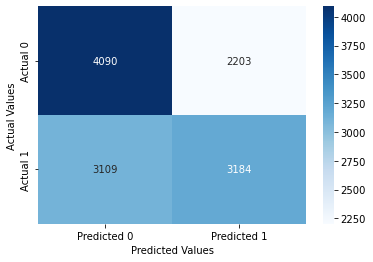

In [156]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, logit_model_age_dummy_3, cutoff=0.5)

Classification accuracy = 62.8%
Precision = 12.4%
TPR or Recall = 50.3%
FNR = 49.7%
FPR = 36.0%
ROC-AUC = 60.5%


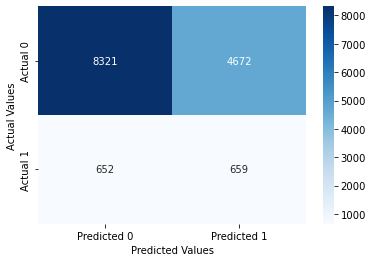

In [157]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, logit_model_age_dummy_3, cutoff=0.5)

#### Model 2: `readmitted ~ num_of_changes*time_in_hospital + number_inpatient + age`

In [109]:
alt_interaction_model = sm.logit('readmitted ~ num_of_changes*time_in_hospital + number_inpatient + age', train1).fit()
alt_interaction_model.summary()

Optimization terminated successfully.
         Current function value: 0.674532
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                12586
Model:                          Logit   Df Residuals:                    12580
Method:                           MLE   Df Model:                            5
Date:                Fri, 24 Feb 2023   Pseudo R-squ.:                 0.02686
Time:                        00:54:09   Log-Likelihood:                -8489.7
converged:                       True   LL-Null:                       -8724.0
Covariance Type:            nonrobust   LLR p-value:                 4.789e-99
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -1.0462      0.085    -12.245      0.000      -1.214      -0.879
num_of_changes                      0.1460      0.073      1.989      0.047       0.002       0.290
time_in_hospital                    0.0623      0.007      8.469      0.000       0.048       0.077
num_of_changes:time_in_hospital    -0.0070      0.012     -0.574      0.566      -0.031       0.017
number_inpatient                    0.4191      0.030     14.039      0.000       0.361       0.478
age                                 0.0096      0.001      8.124      0.000       0.007       0.012
===================================================================================================
"""

Model 2.1 -- Making each `time_in_hospital` group its own predictor

In [167]:
form = 'readmitted ~ time_in_hospital + ' + ' + '.join(vars[1]) + ' + num_of_changes + number_inpatient'
form

'readmitted ~ time_in_hospital + time_in_hospital1 + time_in_hospital2 + time_in_hospital3 + time_in_hospital4 + time_in_hospital5 + time_in_hospital6 + time_in_hospital7 + time_in_hospital8 + time_in_hospital9 + time_in_hospital10 + time_in_hospital11 + time_in_hospital12 + time_in_hospital13 + time_in_hospital14 + num_of_changes + number_inpatient'

In [168]:
alt_interaction_model_timepred = sm.logit(formula = form, data = train1_dummy).fit() 
alt_interaction_model_timepred.summary()

         Current function value: 0.675635
         Iterations: 35


/Users/amywang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                12586
Model:                          Logit   Df Residuals:                    12569
Method:                           MLE   Df Model:                           16
Date:                Fri, 24 Feb 2023   Pseudo R-squ.:                 0.02527
Time:                        01:27:23   Log-Likelihood:                -8503.5
converged:                      False   LL-Null:                       -8724.0
Covariance Type:            nonrobust   LLR p-value:                 9.782e-84
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.2142   2.06e+05  -1.04e-06      1.000   -4.04e+05    4.04e+05
time_in_hospital       0.0333        nan        nan        nan         nan         nan
time_in_hospital1     -0.3075   3.49e+05  -8.82e-07      1.000   -6.83e+05    6.83e+05
time_in_hospital2     -0.1780   4.41e+05  -4.03e-07      1.000   -8.65e+05    8.65e+05
time_in_hospital3     -0.0575   5.11e+05  -1.13e-07      1.000      -1e+06       1e+06
time_in_hospital4     -0.0398   5.68e+05     -7e-08      1.000   -1.11e+06    1.11e+06
time_in_hospital5      0.0589   6.14e+05    9.6e-08      1.000    -1.2e+06     1.2e+06
time_in_hospital6      0.1328   6.52e+05   2.04e-07      1.000   -1.28e+06    1.28e+06
time_in_hospital7      0.0439   6.84e+05   6.42e-08      1.000   -1.34e+06    1.34e+06
time_in_hospital8      0.1954    7.1e+05   2.75e-07      1.000   -1.39e+06    1.39e+06
time_in_hospital9      0.2478   7.31e+05   3.39e-07      1.000   -1.43e+06    1.43e+06
time_in_hospital10     0.0644   7.47e+05   8.61e-08      1.000   -1.46e+06    1.46e+06
time_in_hospital11    -0.1752   7.59e+05  -2.31e-07      1.000   -1.49e+06    1.49e+06
time_in_hospital12     0.1342   7.67e+05   1.75e-07      1.000    -1.5e+06     1.5e+06
time_in_hospital13    -0.1788   7.71e+05  -2.32e-07      1.000   -1.51e+06    1.51e+06
time_in_hospital14    -0.1547    7.7e+05  -2.01e-07      1.000   -1.51e+06    1.51e+06
num_of_changes         0.0749      0.038      1.958      0.050   -5.84e-05       0.150
number_inpatient       0.4171      0.030     13.892      0.000       0.358       0.476
======================================================================================
"""

Classification accuracy = 57.4%
Precision = 58.0%
TPR or Recall = 53.5%
FNR = 46.5%
FPR = 38.8%
ROC-AUC = 60.1%


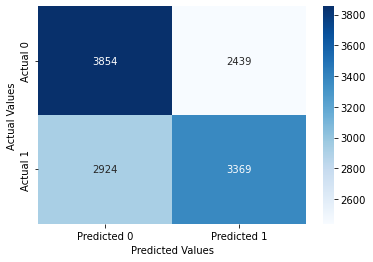

In [181]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, alt_interaction_model_timepred, cutoff=0.5)

Classification accuracy = 59.5%
Precision = 12.2%
TPR or Recall = 55.3%
FNR = 44.7%
FPR = 40.0%
ROC-AUC = 59.8%


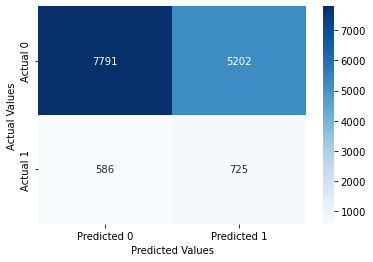

In [182]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, alt_interaction_model_timepred, cutoff=0.5)

Model 2.2: making `time_in_hospital` its own predictor, adding interaction between `time_in_hospital` and `num_of_changes`

In [193]:
form = 'readmitted ~ num_of_changes*{}'.format('num_of_changes*'.join([(x + " + ") for x in vars[1][:-1]]) + 'num_of_changes*time_in_hospital14')
form

'readmitted ~ num_of_changes*time_in_hospital1 + num_of_changes*time_in_hospital2 + num_of_changes*time_in_hospital3 + num_of_changes*time_in_hospital4 + num_of_changes*time_in_hospital5 + num_of_changes*time_in_hospital6 + num_of_changes*time_in_hospital7 + num_of_changes*time_in_hospital8 + num_of_changes*time_in_hospital9 + num_of_changes*time_in_hospital10 + num_of_changes*time_in_hospital11 + num_of_changes*time_in_hospital12 + num_of_changes*time_in_hospital13 + num_of_changes*time_in_hospital14'

In [194]:
alt_interaction_model_timepred_interact = sm.logit(formula = form, data = train1_dummy).fit() 
alt_interaction_model_timepred_interact.summary()

         Current function value: 0.684399
         Iterations: 35


/Users/amywang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                12586
Model:                          Logit   Df Residuals:                    12558
Method:                           MLE   Df Model:                           27
Date:                Fri, 24 Feb 2023   Pseudo R-squ.:                 0.01262
Time:                        01:47:40   Log-Likelihood:                -8613.8
converged:                      False   LL-Null:                       -8724.0
Covariance Type:            nonrobust   LLR p-value:                 3.325e-32
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.1000   5.44e+05   1.84e-07      1.000   -1.07e+06    1.07e+06
num_of_changes                        0.1318        nan        nan        nan         nan         nan
time_in_hospital1                    -0.5419   5.44e+05  -9.97e-07      1.000   -1.07e+06    1.07e+06
num_of_changes:time_in_hospital1      0.1137        nan        nan        nan         nan         nan
time_in_hospital2                    -0.3734   5.44e+05  -6.87e-07      1.000   -1.07e+06    1.07e+06
num_of_changes:time_in_hospital2      0.0912        nan        nan        nan         nan         nan
time_in_hospital3                    -0.1437   5.44e+05  -2.64e-07      1.000   -1.07e+06    1.07e+06
num_of_changes:time_in_hospital3     -0.1899        nan        nan        nan         nan         nan
time_in_hospital4                    -0.1309   5.44e+05  -2.41e-07      1.000   -1.07e+06    1.07e+06
num_of_changes:time_in_hospital4     -0.0237        nan        nan        nan         nan         nan
time_in_hospital5                     0.0385   5.44e+05   7.09e-08      1.000   -1.07e+06    1.07e+06
num_of_changes:time_in_hospital5     -0.1416        nan        nan        nan         nan         nan
time_in_hospital6                     0.1478   5.44e+05   2.72e-07      1.000   -1.07e+06    1.07e+06
num_of_changes:time_in_hospital6     -0.1042        nan        nan        nan         nan         nan
time_in_hospital7                     0.1772   5.44e+05   3.26e-07      1.000   -1.07e+06    1.07e+06
num_of_changes:time_in_hospital7     -0.3500        nan        nan        nan         nan         nan
time_in_hospital8                     0.3623   5.44e+05   6.66e-07      1.000   -1.07e+06    1.07e+06
num_of_changes:time_in_hospital8     -0.3422        nan        nan        nan         nan         nan
time_in_hospital9                     0.3369   5.44e+05    6.2e-07      1.000   -1.07e+06    1.07e+06
num_of_changes:time_in_hospital9      0.0329        nan        nan        nan         nan         nan
time_in_hospital10                    0.0230   5.44e+05   4.23e-08      1.000   -1.07e+06    1.07e+06
num_of_changes:time_in_hospital10     0.4052        nan        nan        nan         nan         nan
time_in_hospital11                   -0.1435   5.44e+05  -2.64e-07      1.000   -1.07e+06    1.07e+06
num_of_changes:time_in_hospital11     0.3798        nan        nan        nan         nan         nan
time_in_hospital12                    0.2659   5.44e+05   4.89e-07      1.000   -1.07e+06    1.07e+06
num_of_changes:time_in_hospital12     0.0390        nan        nan        nan         nan         nan
time_in_hospital13                   -0.0897   5.44e+05  -1.65e-07      1.000   -1.07e+06    1.07e+06
num_of_changes:time_in_hospital13     0.2911        nan        nan        nan         nan         nan
time_in_hospital14                    0.1712   5.44e+05   3.15e-07      1.000  

Classification accuracy = 55.1%
Precision = 56.1%
TPR or Recall = 47.1%
FNR = 52.9%
FPR = 36.9%
ROC-AUC = 57.4%


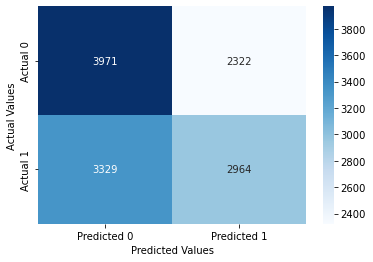

In [195]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, alt_interaction_model_timepred_interact, cutoff=0.5)

Classification accuracy = 60.9%
Precision = 11.4%
TPR or Recall = 48.1%
FNR = 51.9%
FPR = 37.8%
ROC-AUC = 56.7%


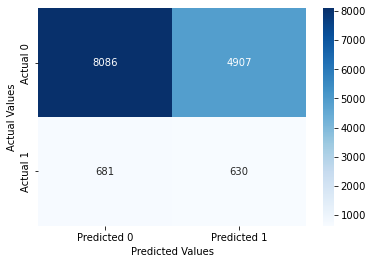

In [196]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, alt_interaction_model_timepred_interact, cutoff=0.5)

This model is decent at predicting true negatives.

Model 2.3: making both `time_in_hospital` and `age` values their own predictors


In [185]:
form = 'readmitted ~ ' + ' + '.join(vars[1]) + ' + num_of_changes + number_inpatient + ' + ' + '.join(vars[0])
form

'readmitted ~ time_in_hospital1 + time_in_hospital2 + time_in_hospital3 + time_in_hospital4 + time_in_hospital5 + time_in_hospital6 + time_in_hospital7 + time_in_hospital8 + time_in_hospital9 + time_in_hospital10 + time_in_hospital11 + time_in_hospital12 + time_in_hospital13 + time_in_hospital14 + num_of_changes + number_inpatient + age5 + age15 + age25 + age35 + age45 + age55 + age65 + age75 + age85 + age95'

In [186]:
alt_interaction_model_timeagepred = sm.logit(formula = form, data = train1_dummy).fit() 
alt_interaction_model_timeagepred.summary()

Optimization terminated successfully.
         Current function value: 0.672479
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                12586
Model:                          Logit   Df Residuals:                    12560
Method:                           MLE   Df Model:                           25
Date:                Fri, 24 Feb 2023   Pseudo R-squ.:                 0.02982
Time:                        01:40:48   Log-Likelihood:                -8463.8
converged:                       True   LL-Null:                       -8724.0
Covariance Type:            nonrobust   LLR p-value:                 4.845e-94
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.2059   1.07e+06  -1.93e-07      1.000   -2.09e+06    2.09e+06
time_in_hospital1     -0.4697   1.76e+05  -2.67e-06      1.000   -3.45e+05    3.45e+05
time_in_hospital2     -0.3197   1.66e+05  -1.93e-06      1.000   -3.25e+05    3.25e+05
time_in_hospital3     -0.1891   1.81e+05  -1.05e-06      1.000   -3.54e+05    3.54e+05
time_in_hospital4     -0.1519   1.71e+05   -8.9e-07      1.000   -3.34e+05    3.34e+05
time_in_hospital5     -0.0301   1.83e+05  -1.65e-07      1.000   -3.58e+05    3.58e+05
time_in_hospital6      0.0776   2.06e+05   3.77e-07      1.000   -4.03e+05    4.03e+05
time_in_hospital7      0.0164   1.74e+05   9.42e-08      1.000   -3.42e+05    3.42e+05
time_in_hospital8      0.1959   1.85e+05   1.06e-06      1.000   -3.62e+05    3.62e+05
time_in_hospital9      0.2859   1.67e+05   1.71e-06      1.000   -3.27e+05    3.27e+05
time_in_hospital10     0.1465    1.7e+05   8.61e-07      1.000   -3.34e+05    3.34e+05
time_in_hospital11    -0.0812   1.84e+05  -4.42e-07      1.000    -3.6e+05     3.6e+05
time_in_hospital12     0.2863   1.72e+05   1.67e-06      1.000   -3.36e+05    3.36e+05
time_in_hospital13    -0.0096   1.73e+05  -5.57e-08      1.000   -3.39e+05    3.39e+05
time_in_hospital14     0.0368   1.65e+05   2.24e-07      1.000   -3.23e+05    3.23e+05
num_of_changes         0.1011      0.039      2.619      0.009       0.025       0.177
number_inpatient       0.4162      0.030     13.918      0.000       0.358       0.475
age5                  -0.9291   3.15e+05  -2.95e-06      1.000   -6.17e+05    6.17e+05
age15                 -0.4017   3.15e+05  -1.28e-06      1.000   -6.17e+05    6.17e+05
age25                 -0.0222   3.15e+05  -7.05e-08      1.000   -6.17e+05    6.17e+05
age35                 -0.0380   3.15e+05  -1.21e-07      1.000   -6.17e+05    6.17e+05
age45                  0.0039   3.15e+05   1.25e-08      1.000   -6.17e+05    6.17e+05
age55                  0.0139   3.15e+05   4.43e-08      1.000   -6.17e+05    6.17e+05
age65                  0.2489   3.15e+05   7.91e-07      1.000   -6.17e+05    6.17e+05
age75                  0.3676   3.15e+05   1.17e-06      1.000   -6.17e+05    6.17e+05
age85                  0.3553   3.15e+05   1.13e-06      1.000   -6.17e+05    6.17e+05
age95                  0.1954   3.15e+05   6.21e-07      1.000   -6.17e+05    6.17e+05
======================================================================================
"""

Classification accuracy = 57.8%
Precision = 58.6%
TPR or Recall = 53.1%
FNR = 46.9%
FPR = 37.5%
ROC-AUC = 61.2%


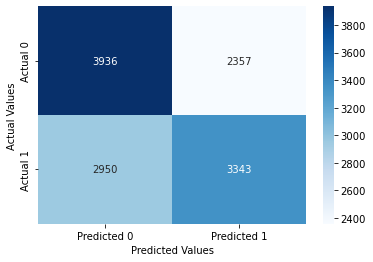

In [191]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, alt_interaction_model_timeagepred, cutoff=0.5)

Classification accuracy = 61.2%
Precision = 12.6%
TPR or Recall = 54.4%
FNR = 45.6%
FPR = 38.1%
ROC-AUC = 60.7%


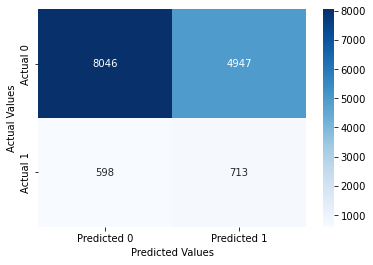

In [188]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, alt_interaction_model_timeagepred, cutoff=0.5)

#### Model 3: `readmitted ~ num_of_changes*time_in_hospital + age*time_in_hospital + number_inpatient`

In [165]:
both_interaction_model = sm.logit('readmitted ~ num_of_changes*time_in_hospital + age*time_in_hospital + number_inpatient', train1).fit()

Optimization terminated successfully.
         Current function value: 0.674417
         Iterations 5


### Exploring diagnoses

In [113]:
train1.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'num_of_changes'],
      dtype='object')

In [129]:
train1.admission_type_id

69952    1
34736    1
7437     1
37190    3
26056    3
        ..
26283    1
64104    1
36963    1
70925    1
55384    1
Name: admission_type_id, Length: 12586, dtype: int64

In [114]:
model_diag = sm.logit(formula = 'readmitted ~ diag_1', data = train1).fit() 
model_diag.summary()

Optimization terminated successfully.
         Current function value: 0.690176
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                12586
Model:                          Logit   Df Residuals:                    12576
Method:                           MLE   Df Model:                            9
Date:                Fri, 24 Feb 2023   Pseudo R-squ.:                0.004287
Time:                        00:58:00   Log-Likelihood:                -8686.5
converged:                       True   LL-Null:                       -8724.0
Covariance Type:            nonrobust   LLR p-value:                 1.730e-12
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.1087      0.032      3.408      0.001       0.046       0.171
diag_1[T.diabetes]           -0.0679      0.070     -0.970      0.332      -0.205       0.069
diag_1[T.digestive]          -0.2563      0.068     -3.784      0.000      -0.389      -0.124
diag_1[T.genitourinary]      -0.0144      0.088     -0.163      0.870      -0.187       0.158
diag_1[T.injury]              0.0823      0.073      1.122      0.262      -0.062       0.226
diag_1[T.musculoskeletal]    -0.1490      0.082     -1.811      0.070      -0.310       0.012
diag_1[T.neoplasms]          -0.0957      0.099     -0.970      0.332      -0.289       0.098
diag_1[T.other]              -0.1087      0.054     -2.019      0.043      -0.214      -0.003
diag_1[T.pregnecy]           -1.0095      0.235     -4.301      0.000      -1.470      -0.549
diag_1[T.respiratory]        -0.3840      0.060     -6.433      0.000      -0.501      -0.267
=============================================================================================
"""

Statistically significant predictors: diag_1[T.digestive], diag_1[T.pregnecy], diag_1[T.respiratory]

Classification accuracy = 52.8%
Precision = 52.0%
TPR or Recall = 74.9%
FNR = 25.1%
FPR = 69.3%
ROC-AUC = 53.9%


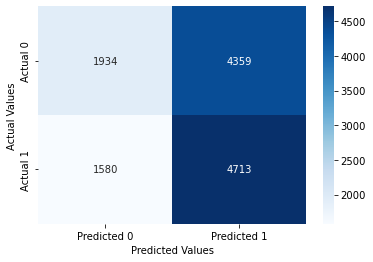

In [158]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, model_diag, cutoff=0.5)

Classification accuracy = 34.3%
Precision = 9.9%
TPR or Recall = 76.6%
FNR = 23.4%
FPR = 70.0%
ROC-AUC = 53.7%


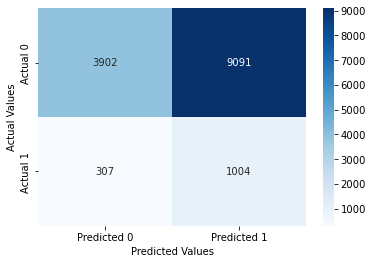

In [159]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, model_diag, cutoff=0.5)

Observations
- Model is better at predicting true positives and not predicting false negatives
- But basically everything is being predicted as negative

In [120]:
model_diag_2 = sm.logit(formula = 'readmitted ~ diag_1 + diag_2', data = train1).fit() 
model_diag_2.summary()

Optimization terminated successfully.
         Current function value: 0.688978
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                12586
Model:                          Logit   Df Residuals:                    12567
Method:                           MLE   Df Model:                           18
Date:                Fri, 24 Feb 2023   Pseudo R-squ.:                0.006015
Time:                        01:01:35   Log-Likelihood:                -8671.5
converged:                       True   LL-Null:                       -8724.0
Covariance Type:            nonrobust   LLR p-value:                 2.721e-14
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.1212      0.037      3.242      0.001       0.048       0.194
diag_1[T.diabetes]           -0.0530      0.073     -0.730      0.465      -0.195       0.089
diag_1[T.digestive]          -0.2854      0.071     -4.013      0.000      -0.425      -0.146
diag_1[T.genitourinary]      -0.0068      0.090     -0.075      0.940      -0.183       0.169
diag_1[T.injury]              0.0840      0.076      1.111      0.266      -0.064       0.232
diag_1[T.musculoskeletal]    -0.1335      0.084     -1.586      0.113      -0.298       0.031
diag_1[T.neoplasms]          -0.2521      0.106     -2.384      0.017      -0.459      -0.045
diag_1[T.other]              -0.1235      0.056     -2.222      0.026      -0.233      -0.015
diag_1[T.pregnecy]           -0.7422      0.328     -2.265      0.024      -1.385      -0.100
diag_1[T.respiratory]        -0.3769      0.060     -6.233      0.000      -0.495      -0.258
diag_2[T.diabetes]            0.0013      0.060      0.022      0.982      -0.116       0.119
diag_2[T.digestive]           0.1254      0.102      1.224      0.221      -0.075       0.326
diag_2[T.genitourinary]      -0.0500      0.073     -0.687      0.492      -0.193       0.093
diag_2[T.injury]              0.0463      0.116      0.400      0.689      -0.180       0.273
diag_2[T.musculoskeletal]    -0.1966      0.140     -1.400      0.161      -0.472       0.079
diag_2[T.neoplasms]           0.5420      0.124      4.366      0.000       0.299       0.785
diag_2[T.other]              -0.0400      0.050     -0.808      0.419      -0.137       0.057
diag_2[T.pregnecy]           -0.5476      0.460     -1.189      0.234      -1.450       0.355
diag_2[T.respiratory]        -0.0769      0.066     -1.163      0.245      -0.207       0.053
=============================================================================================
"""

Statistically significant predictors: 
diag_1[T.digestive], diag_1[T.pregnecy], diag_1[T.respiratory]
diag_1[T.neoplasms], diag_2[T.neoplasms]


Classification accuracy = 53.4%
Precision = 53.1%
TPR or Recall = 57.6%
FNR = 42.4%
FPR = 50.9%
ROC-AUC = 54.8%


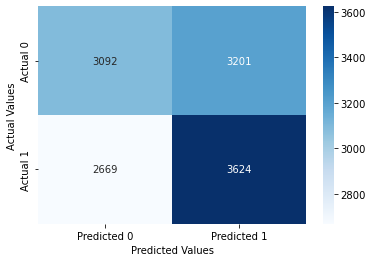

In [161]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, model_diag_2, cutoff=0.5)

Classification accuracy = 48.7%
Precision = 10.0%
TPR or Recall = 57.5%
FNR = 42.5%
FPR = 52.2%
ROC-AUC = 53.8%


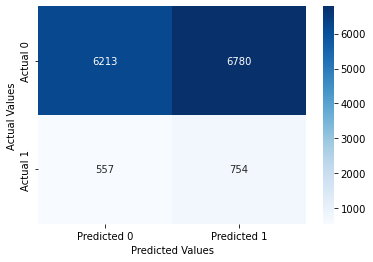

In [162]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, model_diag_2, cutoff=0.5)

In [124]:
model_diag_3 = sm.logit(formula = 'readmitted ~ diag_1 + diag_2 + diag_3', data = train1).fit() 
model_diag_3.summary()

Optimization terminated successfully.
         Current function value: 0.688353
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                12586
Model:                          Logit   Df Residuals:                    12558
Method:                           MLE   Df Model:                           27
Date:                Fri, 24 Feb 2023   Pseudo R-squ.:                0.006916
Time:                        01:02:26   Log-Likelihood:                -8663.6
converged:                       True   LL-Null:                       -8724.0
Covariance Type:            nonrobust   LLR p-value:                 8.303e-14
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.1151      0.044      2.597      0.009       0.028       0.202
diag_1[T.diabetes]           -0.0509      0.074     -0.688      0.491      -0.196       0.094
diag_1[T.digestive]          -0.2939      0.072     -4.089      0.000      -0.435      -0.153
diag_1[T.genitourinary]      -0.0100      0.090     -0.111      0.911      -0.187       0.167
diag_1[T.injury]              0.0847      0.076      1.110      0.267      -0.065       0.234
diag_1[T.musculoskeletal]    -0.1351      0.085     -1.595      0.111      -0.301       0.031
diag_1[T.neoplasms]          -0.2675      0.107     -2.507      0.012      -0.477      -0.058
diag_1[T.other]              -0.1246      0.056     -2.223      0.026      -0.234      -0.015
diag_1[T.pregnecy]           -0.0702      0.403     -0.174      0.862      -0.860       0.719
diag_1[T.respiratory]        -0.3772      0.061     -6.227      0.000      -0.496      -0.258
diag_2[T.diabetes]            0.0049      0.061      0.081      0.935      -0.115       0.124
diag_2[T.digestive]           0.1108      0.103      1.071      0.284      -0.092       0.313
diag_2[T.genitourinary]      -0.0565      0.073     -0.772      0.440      -0.200       0.087
diag_2[T.injury]              0.0275      0.117      0.235      0.814      -0.201       0.256
diag_2[T.musculoskeletal]    -0.2023      0.142     -1.427      0.154      -0.480       0.076
diag_2[T.neoplasms]           0.5157      0.128      4.025      0.000       0.265       0.767
diag_2[T.other]              -0.0412      0.050     -0.827      0.408      -0.139       0.056
diag_2[T.pregnecy]           -0.6274      0.484     -1.295      0.195      -1.577       0.322
diag_2[T.respiratory]        -0.0792      0.066     -1.195      0.232      -0.209       0.051
diag_3[T.diabetes]           -0.0223      0.055     -0.406      0.684      -0.130       0.085
diag_3[T.digestive]           0.1329      0.099      1.344      0.179      -0.061       0.327
diag_3[T.genitourinary]       0.0729      0.080      0.912      0.362      -0.084       0.229
diag_3[T.injury]              0.1220      0.130      0.937      0.349      -0.133       0.377
diag_3[T.musculoskeletal]     0.1287      0.142      0.904      0.366      -0.150       0.408
diag_3[T.neoplasms]           0.1130      0.140      0.807      0.419      -0.161       0.387
diag_3[T.other]              -0.0279      0.048     -0.582      0.560      -0.122       0.066
diag_3[T.pregnecy]           -1.4373      0.519     -2.771      0.006      -2.454      -0.421
diag_3[T.respiratory]         0.0709      0.074      0.957      0.338      -0.074       0.216
=============================================================================================
"""

Classification accuracy = 53.9%
Precision = 53.4%
TPR or Recall = 60.0%
FNR = 40.0%
FPR = 52.3%
ROC-AUC = 55.0%


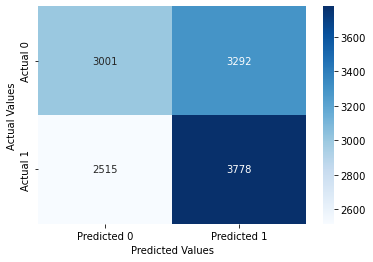

In [163]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, model_diag_3, cutoff=0.5)

Classification accuracy = 48.0%
Precision = 10.3%
TPR or Recall = 60.6%
FNR = 39.4%
FPR = 53.3%
ROC-AUC = 54.5%


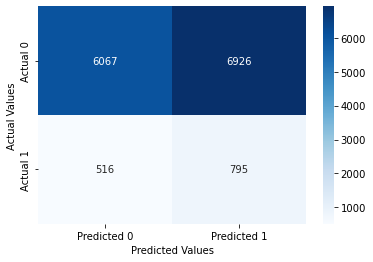

In [164]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, model_diag_3, cutoff=0.5)

#### Exploring admission_type_id, discharge_disposition_id, admission_source_id; each their own predictor after we binned in data cleaning